In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sys.path.append("../")

In [3]:
from utils import from_pickle, to_pickle

In [4]:
os.makedirs("outputs/", exist_ok=True)

In [5]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [6]:
GEOPHYS_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geophys/"
GEOCHEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geochem/"
GEO_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/BC_digital_geology_shp/"
MIN_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Minfile/"

In [7]:
geo_channels = from_pickle("./outputs/geo_channels.pkl")
geophys_channels = from_pickle("./outputs/geophys_channels.pkl")
geochem_channels = from_pickle("./outputs/geochem_channels.pkl")

ix_pos, iy_pos = from_pickle("./outputs/postive_locations.pkl")
ix_neg, iy_neg = from_pickle("./outputs/negative_locations.pkl")

# Merge Channels
- Merge various geo channels into a single tensor

In [8]:
for key, value in geo_channels.items():
    print(key + " shape:", value.shape)

topo shape: (3433, 4287, 1)
cover shape: (3433, 4287, 1)
fault shape: (3433, 4287, 1)
lith shape: (3433, 4287, 59)
class shape: (3433, 4287, 7)
age shape: (3433, 4287, 17)


In [9]:
for key, value in geophys_channels.items():
    print(key + " shape:", value.shape)

total_mag shape: (3433, 4287, 1)
vert_deriv shape: (3433, 4287, 1)


In [10]:
for key, value in geochem_channels.items():
    print(key + " shape:", value.shape)

pca shape: (3433, 4287, 33)


In [11]:
channels = [
    *geo_channels.values(),
    *geophys_channels.values(),
    *geochem_channels.values(),
]
tensor = np.concatenate(channels, axis=-1)
n_channels = tensor.shape[-1]
print(tensor.shape)

(3433, 4287, 121)


# Extract Training Examples

In [12]:
# 100 pixels = 2.5 km
wx = 100
wy = 100

In [13]:
def extract_windows(ix, iy, wx, wy, tensor, nan_value=0.0):
    """get windows surrounding (ix, iy)"""
    windows = np.zeros((len(ix), wx, wy, tensor.shape[-1]))
    for iloc, (iix, iiy) in enumerate(zip(ix, iy)):
        ix_min = np.int(iix - wx / 2)
        iy_min = np.int(iiy - wy / 2)
        img = tensor[iy_min : iy_min + wy, ix_min : ix_min + wx, :]
        windows[iloc, ...] = np.nan_to_num(img, nan=nan_value)
    return windows

## Positive

In [14]:
examples_pos = extract_windows(ix_pos, iy_pos, wx, wy, tensor)
print(examples_pos.shape)

(57, 100, 100, 121)


In [15]:
labels_pos = np.ones(len(ix_pos))
print(labels_pos.shape)

(57,)


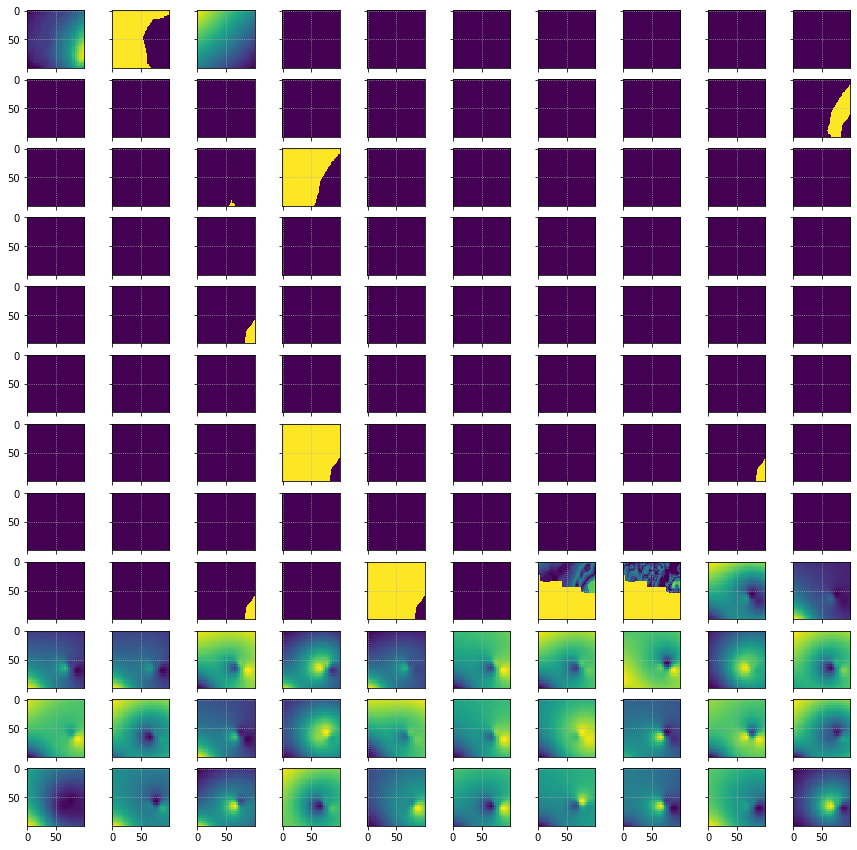

In [16]:
fig, axes = plt.subplots(12, 10, figsize=(15, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 0
for c, ax in enumerate(axes):
    ax.imshow(examples_pos[i, ..., c])

## Negative

In [17]:
examples_neg = extract_windows(ix_neg, iy_neg, wx, wy, tensor)
print(examples_neg.shape)

(57, 100, 100, 121)


In [18]:
labels_neg = np.zeros(len(ix_neg))
print(labels_neg.shape)

(57,)


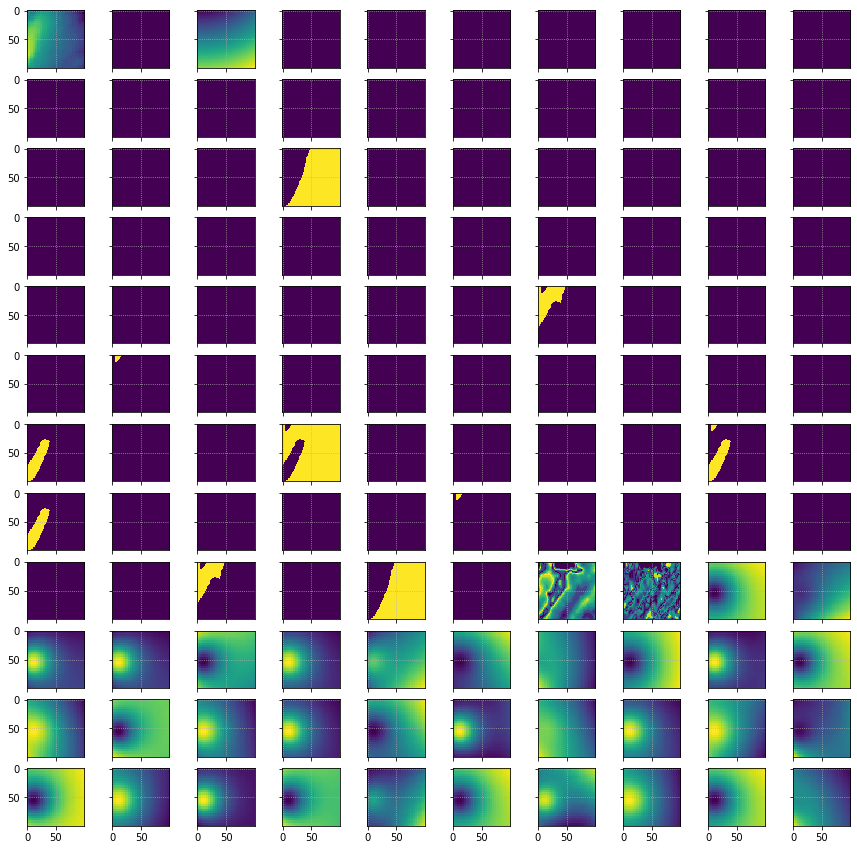

In [19]:
fig, axes = plt.subplots(12, 10, figsize=(15, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 10
for c, ax in enumerate(axes):
    ax.imshow(examples_neg[i][..., c])

## Training and Test Set

In [20]:
train_examples = np.concatenate((examples_pos, examples_neg), axis=0)
print(train_examples.shape)

(114, 100, 100, 121)


In [21]:
train_labels = np.concatenate((labels_pos, labels_neg), axis=0)
print(train_labels.shape)

(114,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    train_examples, train_labels, test_size=0.25, random_state=42
)
print(X_train.shape)
print(X_test.shape)

(85, 100, 100, 121)
(29, 100, 100, 121)


In [23]:
def ND_scaler(tensor, train=True, feature_range=(0, 1), scalers=None):
    """
    batch min max scaler of tensors shaped (batch, ny, nx, nc)
    https://stackoverflow.com/questions/58646790/python-scaling-with-4d-data
    """
    return_scalers = {}
    transformed_tensor = np.zeros_like(tensor)
    nc = tensor.shape[-1]
    for i in range(nc):
        if train:
            scaler = MinMaxScaler(feature_range)
        else:
            scaler = scalers[i]
        row_vectors = tensor[..., i].reshape(
            tensor.shape[0], tensor.shape[1] * tensor.shape[2]
        )
        scaled = scaler.fit_transform(row_vectors)
        scaled = scaled.reshape(
            tensor.shape[0], tensor.shape[1], tensor.shape[2]
        )
        transformed_tensor[..., i] = scaled
        return_scalers[i] = scaler

    return [transformed_tensor, return_scalers] if train else transformed_tensor

In [24]:
row_vectors = X_train[..., 0].reshape(
        X_train.shape[0], X_train.shape[1] * X_train.shape[2]
    )

In [25]:
row_vectors.shape

(85, 10000)

In [26]:
X_train_scaled, scalers = ND_scaler(X_train)

In [27]:
X_test_scaled = ND_scaler(X_test, train=False, scalers=scalers)

In [28]:
# to_pickle(
#     "./outputs/train_test_set.pkl",
#     [X_train_scaled, X_test_scaled, y_train, y_test],
# )
# to_pickle("./outputs/scalers.pkl", scalers)

In [29]:
to_pickle(
    "./outputs/train_test_set.pkl",
    [X_train, X_test, y_train, y_test],
)